# Genomic Vulnerability Mapping

In [13]:
import Pkg
Pkg.activate("..")
Pkg.add("JLD2")
Pkg.status()

  Activating project at `~/Documents/Kaizen/code/space-behaviour`
   Resolving package versions...
    Updating `~/Documents/Kaizen/code/space-behaviour/Project.toml`
⌅ [033835bb] + JLD2 v0.4.54
  No Changes to `~/Documents/Kaizen/code/space-behaviour/Manifest.toml`


Status `~/Documents/Kaizen/code/space-behaviour/Project.toml`
  [46ada45e] Agents v6.2.10
  [336ed68f] CSV v0.10.15
⌃ [13f3f980] CairoMakie v0.13.10
  [a93c6f00] DataFrames v1.7.0
  [0c46a032] DifferentialEquations v7.16.1
  [31c24e10] Distributions v0.25.120
  [587475ba] Flux v0.16.5
  [86223c79] Graphs v1.13.0
⌅ [a98d9a8b] Interpolations v0.15.1
⌅ [033835bb] JLD2 v0.4.54
⌅ [ee78f7c6] Makie v0.22.10
  [c3e4b0f8] Pluto v0.20.13
⌃ [7f904dfe] PlutoUI v0.7.68
  [90137ffa] StaticArrays v1.9.14
⌃ [2913bbd2] StatsBase v0.34.5
⌃ [fce5fe82] Turing v0.39.8
  [9a3f8284] Random v1.11.0
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


## Simulating GCR events

Using the methods and functions developed in the previous notebook we can simulate $N$ events and obtain the necessary particle, time, energy and direction for further analysis and modelling

In [23]:
include("../modules/GCRSimulator/GCRSimulator.jl")

PARTICLE_PARAMS = Dict(
        :proton => (γ = 2.7, cutoff = 1.0e4, A = 1.0, weight = 0.87),
        :helium => (γ = 2.58, cutoff = 1.0e4, A = 0.1, weight = 0.12),
        :heavy => (γ = 2.6, cutoff = 1.0e4, A = 0.01, weight = 0.01),
    )

sim = GCRSimulator(PARTICLE_PARAMS; area=1.0)

times, species, energies, directions = simulate_events(sim, round(Int, sim.λ * 3600 * 24))

println("λ = ", sim.λ, " events/s")
println("First 5 events:")
for i in 1:5
    println((times[i], species[i], energies[i], directions[i]))
end

eventlist = [(time = times[i], particle = species[i], energy = energies[i], direction = directions[i]) for i in 1:length(times) if energies[i] > 5]
println("Simulated $(length(eventlist)) events")

λ = 8.264562861287374 events/s
First 5 events:
(0.010018173041005806, :proton, 1.3459060526784308, [0.9232855379819711, -0.3670892269419341, 0.11308985284505205])
(0.05264224041191189, :proton, 1.6377711859381647, [0.031459654192465714, -0.8058172073006039, 0.5913280972322776])
(0.481735835327002, :proton, 1.2128627187370091, [0.9996287213299562, -0.0060186822759766044, -0.026574328888942])
(0.4976855819619482, :helium, 27.33585021147997, [0.9854920441966203, 0.10876061279072977, 0.1302941285344483])
(0.5692418191571021, :proton, 1.2441842142683275, [0.5501301606490696, 0.22245204910255087, -0.8049048963662137])
Simulated 47600 events


In [3]:
energies = [e.energy for e in eventlist]


describe(energies)

Summary Stats:
Length:         47702
Missing Count:  0
Mean:           12.434517
Std. Deviation: 32.528769
Minimum:        5.000082
1st Quartile:   5.929681
Median:         7.544116
3rd Quartile:   11.413715
Maximum:        2692.632709
Type:           Float64


## Estimating DSBs for each GCR event

### Calculating Linear Energy Transfer (LET)

LET describes how densely energy is deposited along a track in a medium.

It can be calculated using stopping power values for ions in different mediums available from NIST

*M.J. Berger et al., ESTAR, PSTAR, and ASTAR: Computer Programs for Calculating Stopping‑Power and Range Tables for Electrons, Protons, and Helium Ions (NIST SRD 124)*

In [4]:
using CSV
using DataFrames
using Interpolations

function loadLETfromNIST(filepath; use_total = false, density = 1.0)
    datapath = ("../data/stopping-power")
    df = CSV.read(
    joinpath(datapath, filepath), 
    DataFrame;
    header = 8,
    delim='\t', 
    ignorerepeated=true
    )

    rename!(df, Dict(
        names(df)[1] => "energy_MeV",
        names(df)[2] => "electron_MeVcm2g",
        names(df)[3] => "nuclear_MeVcm2g",
        names(df)[4] => "total_MeVcm2g"
    ))

    for col in names(df)
        df[!, col] = Float64.(df[!, col])
    end

    colname = use_total ? "total_MeVcm2g" : "electron_MeVcm2g"

    LET_keV_per_μm = df[!, colname] .* density .* 0.1

    return LinearInterpolation(df.energy_MeV, LET_keV_per_μm, extrapolation_bc=Flat())

end

protonLET = loadLETfromNIST("protons-in-water.tsv")
alphaLET = loadLETfromNIST("alpha-in-water.tsv")

nothing

In [5]:
using CSV
using DataFrames
using Interpolations

function loadLETfromSRIM(filepath; density = 1.0)

    datapath = joinpath("../data/stopping-power", filepath)
    df = CSV.read(
        datapath,
        DataFrame;
        header = 0,
        delim = "\t",
        ignorerepeated = true
        )

    rename!(df, Dict(
        names(df)[1] => "Energy (MeV)",
        names(df)[2] => "Stopping Power (MeV cm2 g-1)",
        names(df)[3] => "Ionising Dose (MeV g-1)",
        names(df)[4] => "Ionising Dose (Gy)"
    ))

    for col in names(df)
        df[!, col] = Float64.(df[!, col])
    end   

    LET_keV_per_μm = df[!, "Stopping Power (MeV cm2 g-1)"] .* density .* 0.1


    return LinearInterpolation(df[:, "Energy (MeV)"], LET_keV_per_μm, extrapolation_bc=Flat())
end

ironLET = loadLETfromSRIM("iron-in-water.tsv")
nothing

In [15]:
lookupLET = Dict(
    :proton => protonLET,
    :helium => alphaLET,
    :heavy => ironLET
)

LETs = [lookupLET[e.particle](e.energy) for e in eventlist]

# LETprotons = [lookupLET[e.particle](e.energy) for e in eventlist if e.particle == :proton]

describe(LETs)

Summary Stats:
Length:         47702
Missing Count:  0
Mean:           42.058547
Std. Deviation: 285.808531
Minimum:        0.200284
1st Quartile:   4.472342
Median:         6.196854
3rd Quartile:   7.475964
Maximum:        4708.811189
Type:           Float64


### Simulating DSBs based on PARTRAC

PARTRACs LET $\to$ DSBs per cell per gray mapping is the outcome of simulating physical geometry, chemical activity and biological structure

They formulated a power-law with saturation that best fit the data they obtained from monte-carlo simulations 



Reference:
*Kundrát, P., Friedland, W., Becker, J. _et al._ Analytical formulas representing track-structure simulations on DNA damage induced by protons and light ions at radiotherapy-relevant energies. _Sci Rep_ **10**, 15775 (2020). https://doi.org/10.1038/s41598-020-72857-z*

In [6]:
PARTRAC_PARAMS = Dict(
  :proton => (p1=6.8, p2=37.22, p3=0.6415, p4=7.099, p5=4.083),
  :helium => (p1=6.8, p2=10.56, p3=0.6902, p4=1.331, p5=1.317),
  :heavy  => (p1=6.8, p2=9.604, p3=0.6996, p4=1.425, p5=1.318),
)

function dsb_yield(LET::Float64, species::Symbol)
    p = PARTRAC_PARAMS[species]
    num = p.p1 + (p.p2 * LET)^p.p3
    den = 1 + (p.p4 * LET)^p.p5
    return num/den
end

dsb_yield (generic function with 1 method)

In [ ]:
LET_test = 100.0  # keV/μm
@show dsb_yield(LET_test, :proton)

In [8]:
function estimateDSBs(event)
    
    LET = lookupLET[event.particle](event.energy) # keV/μm
    
    Gbp = 6.4 # human genome size
    mass = 6e-12 # nuclear mass in g
    track = 10.0 # full traversal through cell in μm (worst case scenario)
    
    dose = (LET * track)/mass # keV/g
    dose_Gy = dose / 6.24e12 # Gy/g

    yield = dsb_yield(LET, event.particle) # DSBs/(Gy⋅Gbp)

    return dose_Gy * yield * Gbp
end

estimateDSBs (generic function with 1 method)

In [11]:
proton_events = filter(e -> e.particle == :proton, eventlist)
proton_LETs   = [lookupLET[e.particle](e.energy) for e in proton_events]
proton_yields = [dsb_yield(LET, :proton) for LET in proton_LETs]

println("Median LET: ", median(proton_LETs))
println("Median yield: ", median(proton_yields))
println("Max LET: ", maximum(proton_LETs))
println("Max yield: ", maximum(proton_yields))

Median LET: 5.734465422305347
Median yield: 1.0173668572684013e-5
Max LET: 7.9059074073565965
Max yield: 2.0023377137519547


In [14]:
using JLD2
@save "../data/dose-to-damage-data.jld2" lookupLET PARTRAC_PARAMS

### Visualing DSBs over time

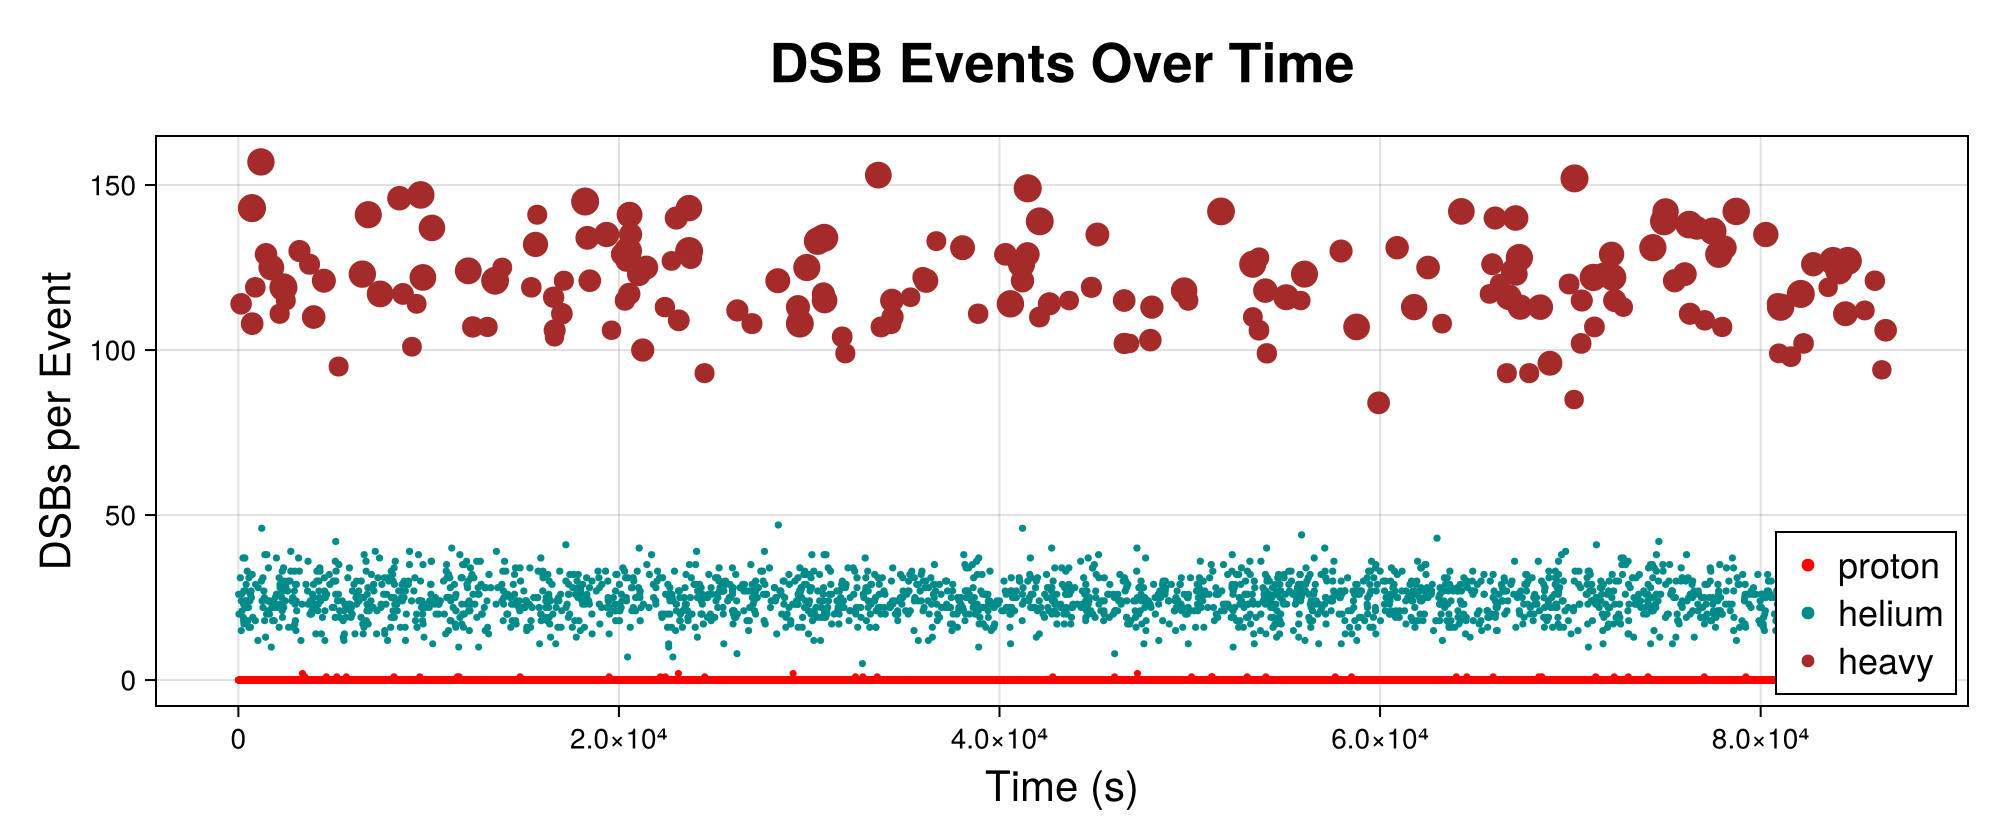

In [18]:
using CairoMakie, Distributions

fig = Figure(size=(1000, 420))
ax = Axis(fig[1, 1],
    xlabel = "Time (s)",
    ylabel = "DSBs per Event",
    # yscale = log,
    title = "DSB Events Over Time",
    titlesize = 27,
    titlegap = 21,
    xlabelsize = 21,
    ylabelsize = 21
)

# Map particle type to color
color_map = Dict(:proton => :red, :helium => :darkcyan, :heavy => :brown)

# Precompute DSBs and LETs
times = [e.time for e in eventlist]
species = [e.particle for e in eventlist]
energies = [e.energy for e in eventlist]
dsbs_expectation = [estimateDSBs(e) for e in eventlist]
dsbs = [rand(Poisson(expectation)) for expectation in dsbs_expectation]
lets = [lookupLET[e.particle](e.energy) for e in eventlist]

# Scale LETs to marker sizes
let_min, let_max = minimum(lets), maximum(lets)
sizes = [5 + (l - let_min) / (let_max - let_min) * 15 for l in lets]

# Group and batch-plot per species
for s in (:proton, :helium, :heavy)
    idx = findall(x -> x == s, species)
    scatter!(
        ax,
        times[idx], dsbs[idx];
        markersize = sizes[idx],
        color = color_map[s],
        label = string(s)
    )
end

axislegend(ax; position = :rb, labelsize = 18)
fig

In [ ]:
describe(dsbs)

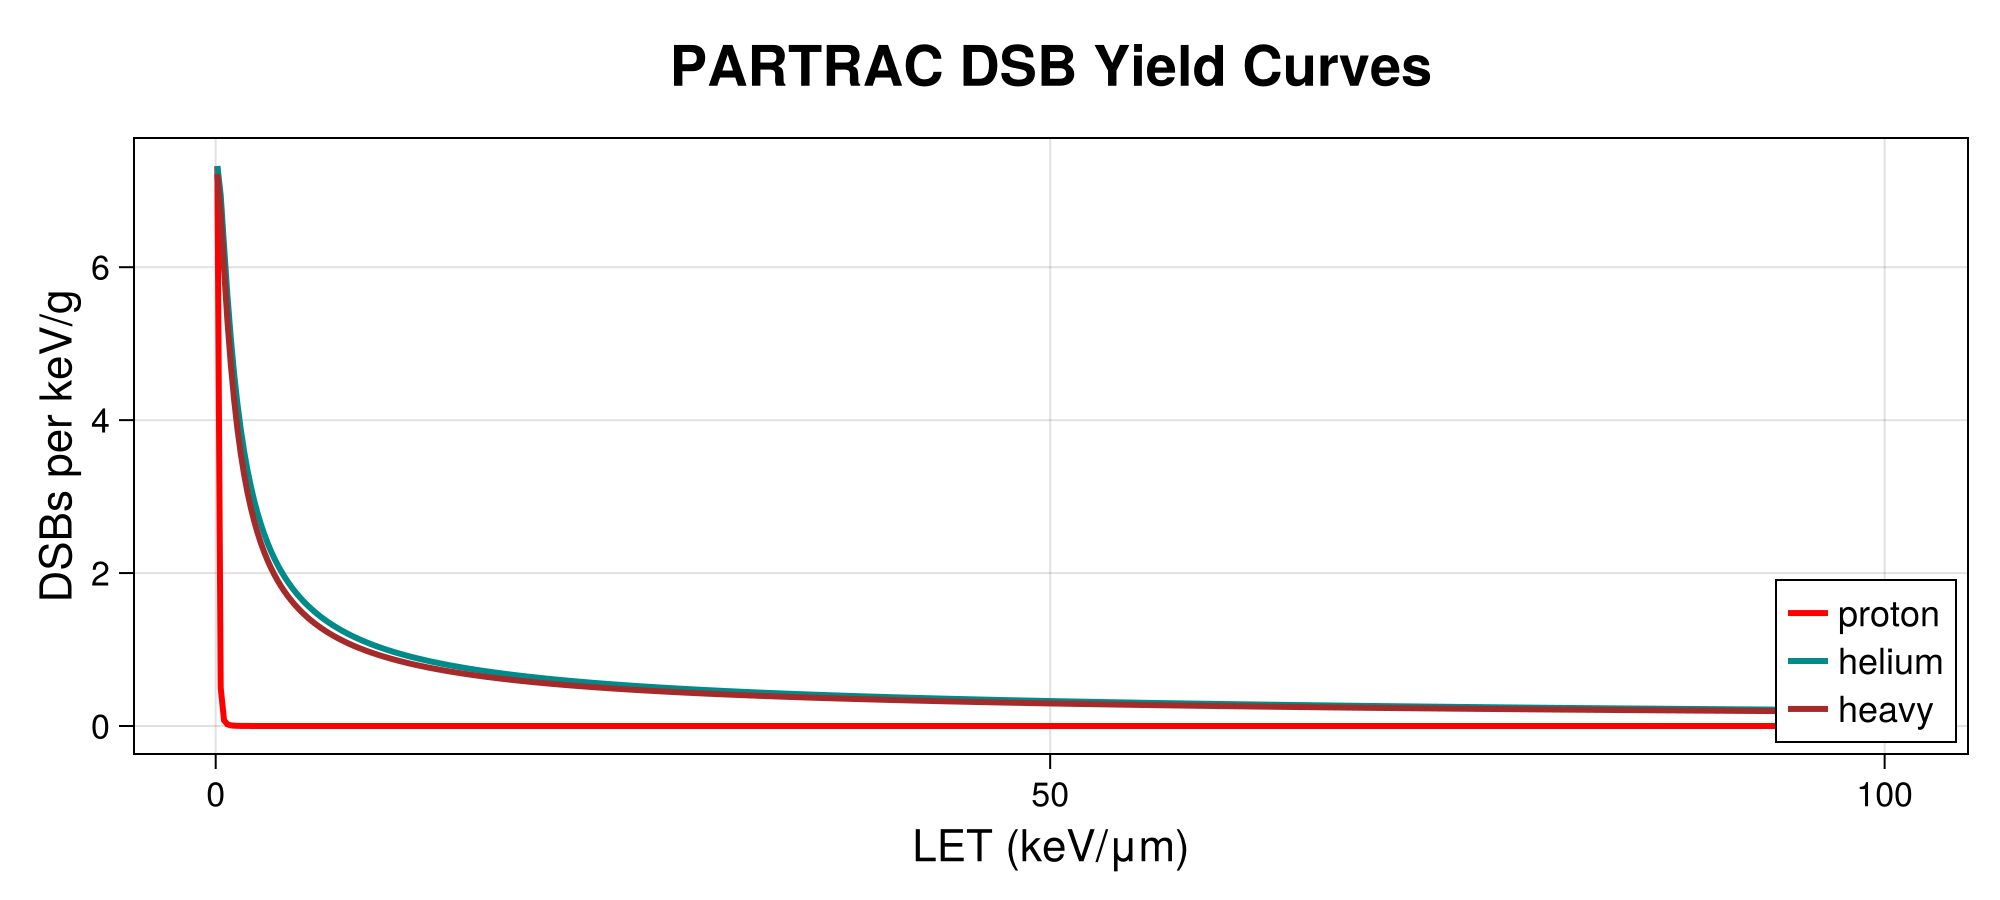

In [16]:
using CairoMakie

fig = Figure(size=(1000, 450))

ax1 = Axis(
    fig[1, 1],
    xlabel = "LET (keV/μm)",
    ylabel = "DSBs per keV/g",
    title = "PARTRAC DSB Yield Curves",
    titlegap = 20,
    titlesize = 28,
    xlabelsize = 22,
    ylabelsize = 22,
    xticklabelsize = 17,
    yticklabelsize = 17,
    xticksize = 7,
    yticksize = 7,
)

LETs = range(0.1, 100.0; length=500)

colors = (:red, :darkcyan, :brown)

for (i, species) in enumerate([:proton, :helium, :heavy])
    yields = [dsb_yield(LET, species) for LET in LETs]
    lines!(ax1, LETs, yields; color=colors[i], label=String(species), linewidth = 3)
end

axislegend(ax1; position = :rb, labelsize=18)
fig
